In [1]:
import os, random, matplotlib, pickle, yaml, hdbscan
import numpy as np
from sklearn.utils import shuffle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

def matplotlib_text(font=SMALL_SIZE, axes_title=SMALL_SIZE, axes_label=MEDIUM_SIZE, xtick=SMALL_SIZE, ytick=SMALL_SIZE, legend=SMALL_SIZE, figure=BIGGER_SIZE):
    plt.rc('font', size=font)          # controls default text sizes
    plt.rc('axes', titlesize=axes_title, labelsize=axes_label)     # fontsize of the axes title
    plt.rc('xtick', labelsize=xtick)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=ytick)    # fontsize of the tick labels
    plt.rc('legend', fontsize=legend)    # legend fontsize
    plt.rc('figure', titlesize=figure)  # fontsize of the figure title

In [3]:
result_path = "../results/round3"
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])

In [4]:
config_path = ".."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
skeleton = config['skeleton']
skeleton_color = config['skeleton_color']

In [5]:
root_path = ".."
rot_bp, angles, limbs = [], [], []
angle_power, limb_power = [], []
all_embed = []
labels = []

for file in tqdm(INFO_values):
    # Signal
    rot_bp.append( np.load(f"{root_path}/{file['directory']}/rotated_bodypoints.npy") )
    angles.append( np.load(f"{root_path}/{file['directory']}/angles.npy") )
    limbs.append( np.load(f"{root_path}/{file['directory']}/limbs.npy") )
    # Power
    angle_power.append( np.load(f"{root_path}/{file['directory']}/angle_power.npy") )
    limb_power.append( np.load(f"{root_path}/{file['directory']}/limb_power.npy") )
    # Embeddings
    all_embed.append( np.load(f"{root_path}/{file['directory']}/all_embeddings.npy") )
    # Clusters
    labels.append( np.load(f"{root_path}/{file['directory']}/cluster.npy") )
    
# Signal
rot_bp = np.concatenate(rot_bp)
angles = np.concatenate(angles)
limbs = np.concatenate(limbs)
# Power
angle_power = np.concatenate(angle_power)
limb_power = np.concatenate(limb_power)
# Embeddings
all_embed = np.concatenate(all_embed)
# Clusters
labels = np.concatenate(labels)

In [ ]:
num_fr = len(all_embed)
(good_fr, good_bp) = np.where( ~np.isnan(all_embed) )
(bad_fr, bad_bp) = np.where( np.isnan(all_embed) )

good_fr = np.unique(good_fr)
bad_fr = np.unique(bad_fr)

limb_min, limb_max = np.min(limbs[good_fr,:]), np.max(limbs[good_fr,:])
limb_power_min, limb_power_max = np.min(limb_power[good_fr,:,:]), np.max(limb_power[good_fr,:,:])

<hr>
<hr>

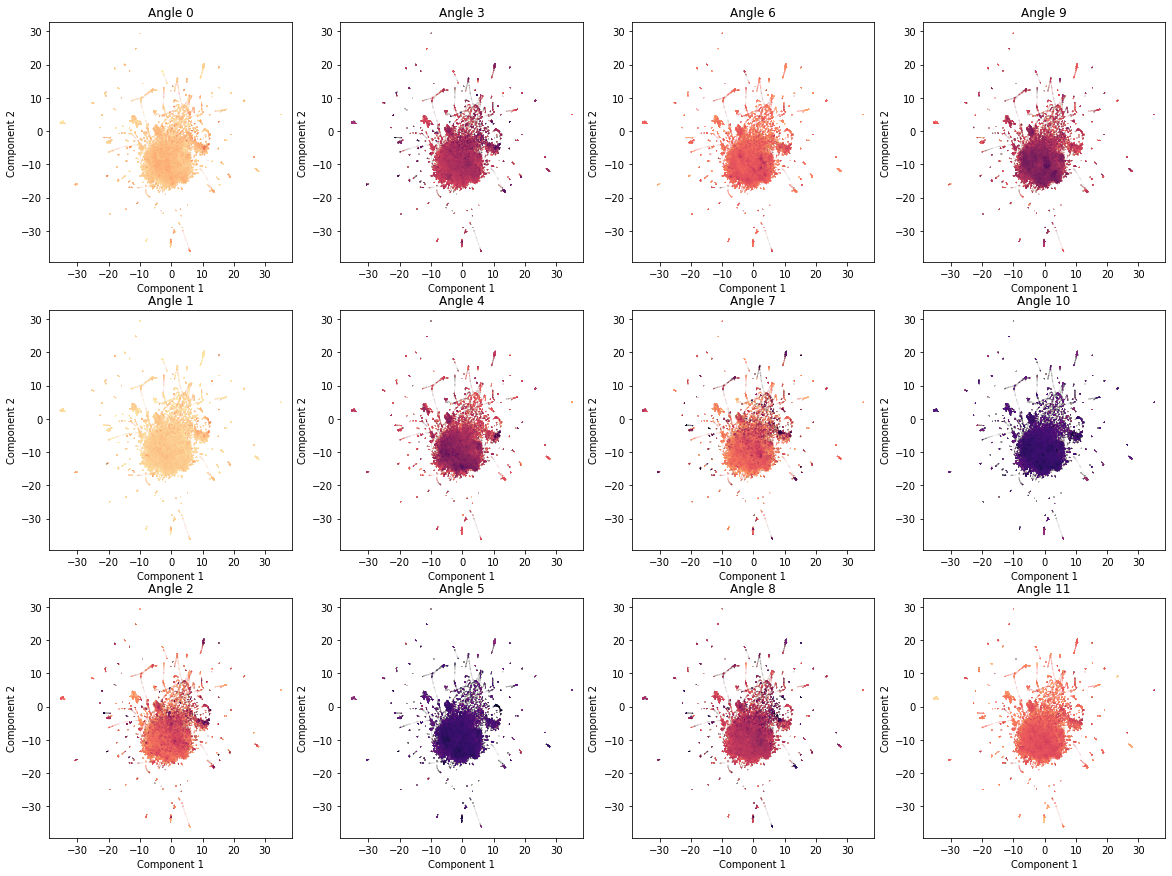

In [31]:
num_fr, num_ang, _ = angles.shape

num_row, num_col = 3, 4
fig, ax = plt.subplots(num_row,num_col, figsize=(int(num_col*5),int(num_row*5)))
                       
for angle_idx in tqdm(range(12)):
    data = angles[:,angle_idx,0]
    norm = matplotlib.colors.Normalize(vmin=np.min(data), vmax=np.max(data))

    ax[angle_idx%num_row, angle_idx//num_row].scatter(all_embed[:,0], all_embed[:,1], c=data, norm=norm ,s=1, alpha=0.005, cmap="magma")
    ax[angle_idx%num_row, angle_idx//num_row].set(xlabel='Component 1', ylabel='Component 2', title=f"Angle {angle_idx}")
plt.show()

# Colorbar
# fig, ax = plt.subplots(figsize=(5, 1))
# fig.subplots_adjust(bottom=0.5)
# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap("magma"), norm=norm, orientation='horizontal')
# cb1.set_label('(Angle)')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.show()

<hr>
<hr>

# Locate stationary cluster

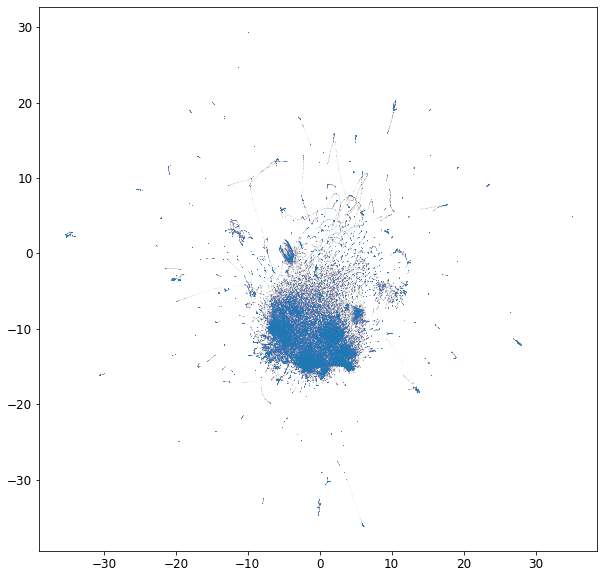

In [302]:
fig_base, ax_base = plt.subplots(figsize=(10,10))
ax_base.scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
plt.show()

In [324]:
leg_idx = (4,5,6,9,10,11)

# sum_freq = np.sum(angle_power[:,:,leg_idx], axis=1)
min_freq = angle_power[:,0,leg_idx]
(stat_fr, stat_bp) = np.where(min_freq > 2)

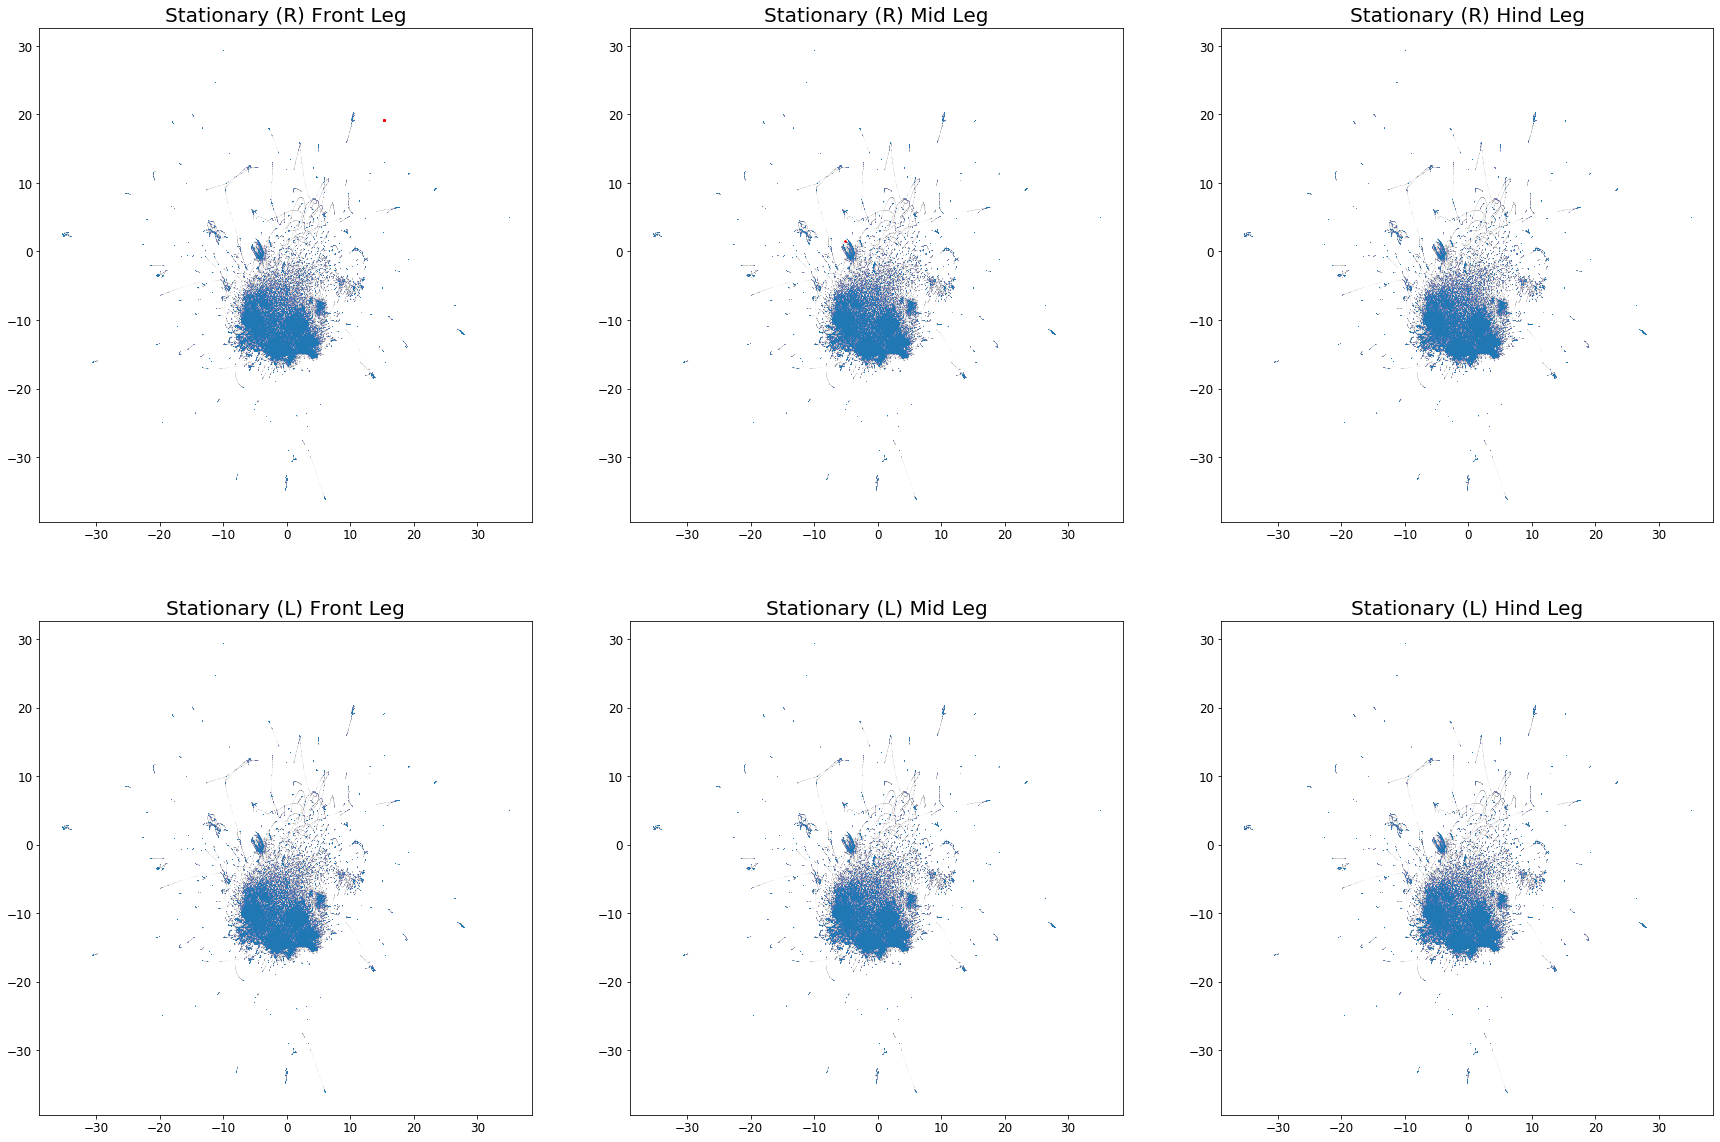

In [326]:
fig, ax = plt.subplots(2,3,figsize=(30,20))

for bp_i in range(len(leg_idx)):
    idx = (stat_bp == bp_i)
    stat_bp_fr = stat_fr[idx]
    
    ax[bp_i//3, bp_i%3].scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
    ax[bp_i//3, bp_i%3].scatter(all_embed[stat_bp_fr,0], all_embed[stat_bp_fr,1], s=1, alpha=0.9, c='r')
    ax[bp_i//3, bp_i%3].set(title=f"Stationary {config['angle_labels'][leg_idx[bp_i]]}", 
                           xlim=ax_base.get_xlim(), ylim=ax_base.get_ylim())
plt.show()

In [325]:
stat_fr.shape

(13681,)

<hr>
<hr>

In [66]:
angles_min, angles_max = np.min(angles[:,:,0], axis=0), np.max(angles[:,:,0], axis=0)
limbs_min, limbs_max = np.min(limbs, axis=0), np.max(limbs, axis=0)
angle_power_min, angle_power_max = np.min(angle_power, axis=(0,1)), np.max(angle_power, axis=(0,1))
limb_power_min, limb_power_max = np.min(limb_power, axis=(0,1)), np.max(limb_power, axis=(0,1))

angles_norm = (angles[:,:,0]-angles_min[np.newaxis,:])/(angles_max[np.newaxis,:]-angles_min[np.newaxis,:])
limbs_norm = (limbs-limbs_min[np.newaxis,:])/(limbs_max[np.newaxis,:]-limbs_min[np.newaxis,:])
angle_power_norm = (angle_power-angle_power_min[np.newaxis,np.newaxis,:])/(angle_power_max[np.newaxis,np.newaxis,:]-angle_power_min[np.newaxis,np.newaxis,:])
limb_power_norm = (limb_power-limb_power_min[np.newaxis,np.newaxis,:])/(limb_power_max[np.newaxis,np.newaxis,:]-limb_power_min[np.newaxis,np.newaxis,:])


In [273]:
num_cluster = int(np.max(labels)+1)
num_angles = angles.shape[1]
num_limbs = limbs.shape[1]
num_angle_power = angle_power.shape[1]*angle_power.shape[2]
num_limb_power = limb_power.shape[1]*limb_power.shape[2]
num_feat = num_angles+num_limbs+num_angle_power+num_limb_power

clust_feat_matrix = np.zeros((num_cluster, num_feat))

for i in tqdm(range(num_cluster)):
    feat_idx = 0
    idx = np.where(labels==i)[0]
    
    clust_feat_matrix[i, feat_idx:feat_idx+num_angles] = np.mean(angles_norm[idx,:], axis=0)
    feat_idx += num_angles
    clust_feat_matrix[i, feat_idx:feat_idx+num_limbs] = np.mean(limbs_norm[idx,:], axis=0)
    feat_idx += num_limbs
    clust_feat_matrix[i, feat_idx:feat_idx+num_angle_power] = np.mean(angle_power_norm[idx,:,:], axis=0).flatten(order='F')
    feat_idx += num_angle_power
    clust_feat_matrix[i, feat_idx:feat_idx+num_limb_power] = np.mean(limb_power_norm[idx,:,:], axis=0).flatten(order='F')

In [274]:
clust_diff_matrix = np.zeros((num_cluster, num_cluster, num_feat))
for i in tqdm(range(num_cluster)):
    for j in range(num_cluster):
        clust_diff_matrix[i,j,:] = clust_feat_matrix[i,:]-clust_feat_matrix[j,:]
cmin, cmax = np.min(clust_diff_matrix), np.max(clust_diff_matrix)
clim = (cmin, cmax)

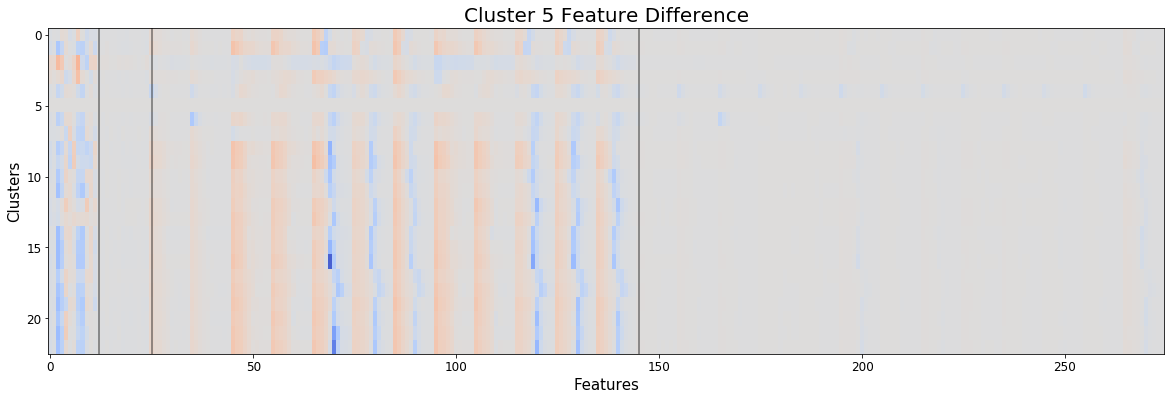

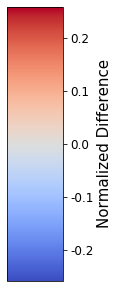

In [275]:
matplotlib_text(axes_title=20, axes_label=15,xtick=12,ytick=12)

norm = matplotlib.colors.Normalize(vmin=cmin, vmax=cmax)

i_clust = 5

fig, ax = plt.subplots(figsize=(20,6))
imshow_ax = ax.imshow(clust_diff_matrix[i_clust,:,:], aspect='auto', cmap='coolwarm', clim=clim)
ax.axvline(x=num_angles, c='k', alpha=0.5)
ax.axvline(x=num_angles+num_limbs, c='k', alpha=0.5)
ax.axvline(x=num_angles+num_limbs+num_angle_power, c='k', alpha=0.5)
ax.set(title=f"Cluster {i_clust} Feature Difference", xlabel="Features", ylabel="Clusters")


fig, ax = plt.subplots(figsize=(1,10))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap("coolwarm"), norm=norm, orientation='vertical')
cb1.set_label('Normalized Difference')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()

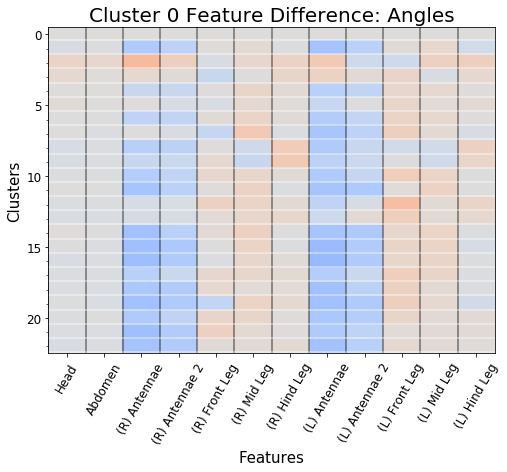

In [276]:
matplotlib_text(axes_title=20,axes_label=15,xtick=12,ytick=12)

i_clust = 0

fig, ax = plt.subplots(figsize=(8,6))
imshow_angle_ax = ax.imshow(clust_diff_matrix[i_clust,:,:num_angles], aspect='auto', cmap='coolwarm', clim=clim)

for interval in np.arange(0,num_angles):
    ax.axvline(x=interval-0.5, c='k', alpha=0.5)
for interval in np.arange(0,num_cluster):
    ax.axhline(y=interval+0.4, c='w', alpha=0.5)

ax.set(title=f"Cluster {i_clust} Feature Difference: Angles", xlabel="Features", ylabel="Clusters",
      xticks=np.arange(0,num_angles))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_xticklabels(config['angle_labels'], rotation=60)
plt.show()

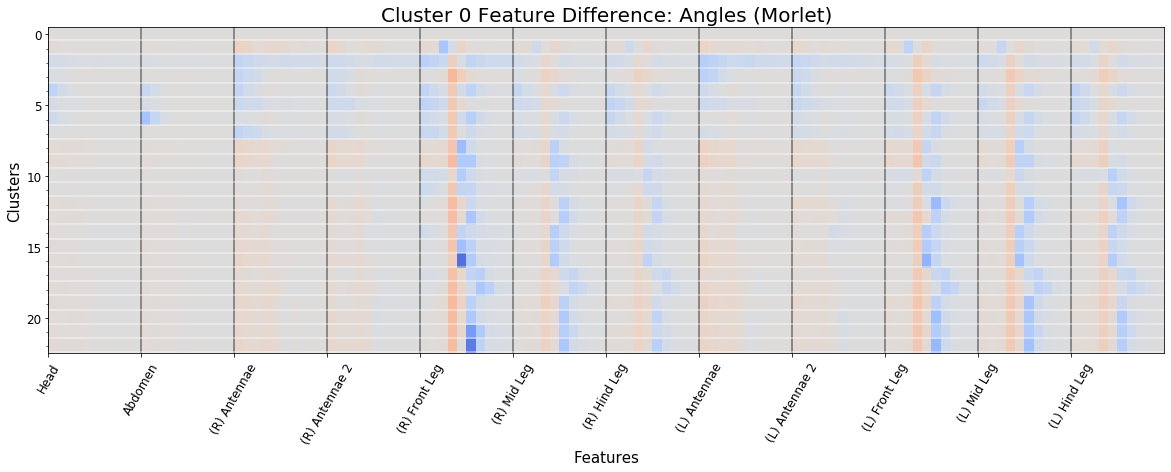

In [277]:
matplotlib_text(axes_title=20, axes_label=15,xtick=12,ytick=12)

i_clust = 0

fig, ax = plt.subplots(figsize=(20,6))
imshow_angle_morlet_ax = ax.imshow(clust_diff_matrix[i_clust,:,num_angles+num_limbs:num_angles+num_limbs+num_angle_power], aspect='auto', cmap='coolwarm', clim=clim)

for interval in range(0,num_angle_power, config['f_bin']):
    ax.axvline(x=interval-0.5, c='k', alpha=0.5)
for interval in np.arange(0,num_cluster):
    ax.axhline(y=interval+0.4, c='w', alpha=0.5)
    
ax.set(title=f"Cluster {i_clust} Feature Difference: Angles (Morlet)", xlabel="Features", ylabel="Clusters",
      xticks=np.arange(0,num_angle_power, config['f_bin'])-0.5)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_xticklabels(config['angle_labels'], rotation=60)
plt.show()